# Image Colorization using DC GAN - Network Architecture 1

## Importing required Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Conv2DTranspose, AveragePooling2D,
                                     Dropout, Input, LeakyReLU, ReLU, Flatten, Dense, UpSampling2D)

from skimage.color import rgb2lab
from skimage.color import lab2rgb


IMAGE_SIZE = 32
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

# WORKDIR = "C:/Users/Sankalp/Desktop/UB/Academics/Summer Semester 2023-24/Deep Learning/Project/"

WORKDIR = '/content/drive/'

## Data Preprocessing

In [3]:
def prepare_dataset(images, show_images=0):

    # Create empty lists
    X = list()
    Y = list()

    for image in images:

        # Normalize the array values to range [0,1]
        image = image / 255

        # Convert RGB image to LAB color space
        lab_image = rgb2lab(image)

        # Segregate the lightness (l) channel
        x = lab_image[:, :, 0]

        # Segregate the 'greenness to redness' (a) and 'blueness to yellowness' (b) channels
        y = lab_image[:, :, 1:]

        # Normalize the values to range [0,1]
        y = y / 128

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))
        Y.append(y)

        if show_images and random.randint(0, 1):
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.title('RGB image')
            plt.imshow(image)

            fig.add_subplot(1, 2, 2)
            plt.title('Normalized LAB image')
            plt.imshow(lab_image)
            plt.show()

            show_images -= 1

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    return X, Y


In [4]:
# Load the CIFAR-10 dataset
(trainset, train_labels), (testset, test_label) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [5]:
print(f"Trainset: {trainset.shape}", end='')
print("         ============>         50,000 32x32 px images with 3 (RGB) channels")
print(f"Testset:  {testset.shape}", end='')
print("         ============>         10,000 32x32 px images with 3 (RGB) channels")

Trainset: (50000, 32, 32, 3)         ============>         50,000 32x32 px images with 3 (RGB) channels
Testset:  (10000, 32, 32, 3)         ============>         10,000 32x32 px images with 3 (RGB) channels


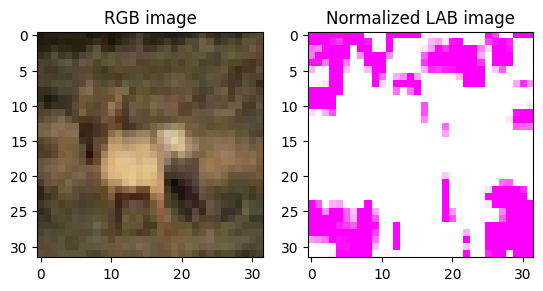

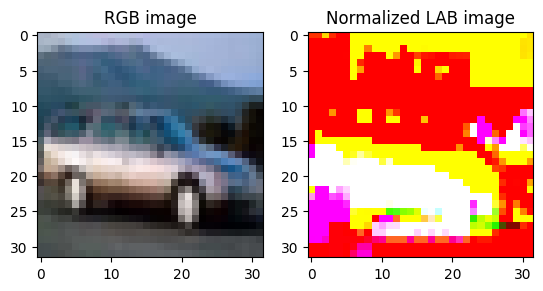

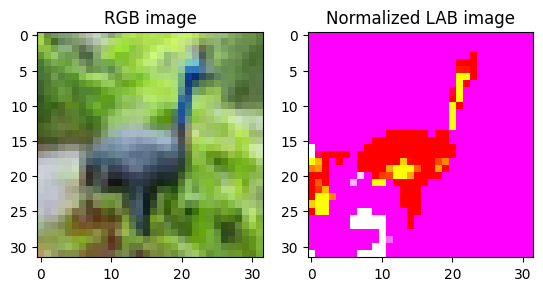

In [6]:
# Prepare the datasets (separate the LAB channels)
X_train, Y_train = prepare_dataset(trainset, show_images = 3)
X_test, Y_test = prepare_dataset(testset)

# Get the slices of arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Generator Model Architecture

In [7]:
class GeneratorModel(tf.keras.Model):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        self.conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
        self.conv2 = Conv2D(64, (3, 3), padding='same', strides=2, activation='relu')
        self.batchnorm1 = BatchNormalization()
        self.conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', strides=2)
        self.conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.batchnorm2 = BatchNormalization()
        self.conv5 = Conv2D(256, (3, 3), padding='same')
        self.activation = Activation('relu')
        self.batchnorm3 = BatchNormalization()
        self.upsampling1 = UpSampling2D(size=(2, 2))
        self.conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.batchnorm4 = BatchNormalization()
        self.upsampling2 = UpSampling2D(size=(2, 2))
        self.conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.batchnorm5 = BatchNormalization()
        self.conv8 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv9 = Conv2D(2, (3, 3), padding='same')
        self.batchnorm6 = BatchNormalization()
        self.activation2 = Activation('tanh')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batchnorm2(x)
        x = self.conv5(x)
        x = self.activation(x)
        x = self.batchnorm3(x)
        x = self.upsampling1(x)
        x = self.conv6(x)
        x = self.batchnorm4(x)
        x = self.upsampling2(x)
        x = self.conv7(x)
        x = self.batchnorm5(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.batchnorm6(x)
        x = self.activation2(x)
        return x


## Discriminator Model Architecture

In [8]:
class DiscriminatorModel(Sequential):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()

        self.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
        self.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Dropout(0.25))

        self.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Dropout(0.25))

        self.add(Flatten())
        self.add(Dense(512))
        self.add(LeakyReLU(0.2))
        self.add(BatchNormalization())
        self.add(Dropout(0.5))
        self.add(Dense(1))
        self.add(Activation('sigmoid'))


In [9]:
# Downsample the images
def downsample(filters, kernel_size, apply_batchnorm=True):

    # Define the initializer for the convolutional layer weights
    initializer = tf.random_uniform_initializer(0, 0.02)

    # Create a Sequential model for downsampling
    model = Sequential()

    # Add a convolutional layer with specified filters, kernel size, and strides
    model.add(Conv2D(filters, kernel_size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))

    # Apply optional BatchNormalization
    if apply_batchnorm:
        model.add(BatchNormalization())

    # Add LeakyReLU layer
    model.add(LeakyReLU())

    return model

# Upsample the images
def upsample(filters, kernel_size, apply_dropout=False):

    # Define the initializer for the convolutional layer weights
    initializer = tf.random_uniform_initializer(0, 0.02)

    # Create a Sequential model for upsampling
    model = Sequential()

    # Add a convolutional layer with specified filters, kernel size, and strides
    model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))

    # Apply BatchNormalization
    model.add(BatchNormalization())

    # Add optional Dropout layer
    if apply_dropout:
        model.add(Dropout(0.5))

    # Add ReLU layer
    model.add(ReLU())

    return model

In [10]:
# Define the Autoencoder Generator Model Architecture
class AutoencoderGeneratorModel(Model):

    def __init__(self):

        super(AutoencoderGeneratorModel, self).__init__()

        # Define input layer
        self.inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

        # Define downsampling layers
        self.downstack = [
            downsample(32, 4, apply_batchnorm=False),
            downsample(64, 4),
            downsample(128, 4),
            downsample(256, 4),
            downsample(256, 4)
        ]

        # Define upsampling layers
        self.upstack = [
            upsample(256, 4, apply_dropout=True),
            upsample(128, 4),
            upsample(64, 4),
            upsample(32, 4),
        ]

        # Define output layer
        initializer = tf.random_uniform_initializer(0, 0.02)
        self.output_layer = Conv2DTranspose(2, 3, strides=2, padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')

    def call(self, image):

        # Downsample the image
        skips = []
        for downsample_image in self.downstack:
            image = downsample_image(image)
            skips.append(image)

        # Reverse the skips list and exclude the last element
        skips = reversed(skips[:-1])

        # Upsample the image
        for upsample_image, skip in zip(self.upstack, skips):
            image = upsample_image(image)
            image = tf.concat([image, skip], axis=-1)

        # Apply the output layer
        image = self.output_layer(image)
        return image


## Training

In [11]:
# Set lambda value as L1-loss multiplier and define the loss function
LAMBDA = 100
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Calculate discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):

    # For the real output, compare it with a tensor of ones
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # For the generated output, compare it with a tensor of zeros
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Compute the total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Calculate generator loss
def generator_loss(disc_generated_output, gen_output, target):

    # For the generated output, compare it with a tensor of ones
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L1 loss as the mean absolute difference between the target and the generated output
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Compute the total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [12]:
generator = AutoencoderGeneratorModel()
discriminator = DiscriminatorModel()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate the image
        gen_output = generator(input_image, training=True)

        # Fetch the real and generated outputs
        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)

        # Compute the generator and discriminator losses
        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize using the gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

In [14]:
# Lists to store loss values
gen_losses = []
disc_losses = []

# Training loop
for epoch in range(EPOCHS):
    gen_loss_total = disc_loss_total = 0
    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate average loss per batch
    gen_loss_avg = gen_loss_total / BATCH_SIZE
    disc_loss_avg = disc_loss_total / BATCH_SIZE

    # Append losses to lists
    gen_losses.append(gen_loss_avg)
    disc_losses.append(disc_loss_avg)

    print(f'Epoch {epoch + 1}: gen loss: {gen_loss_total / BATCH_SIZE}, disc loss: {disc_loss_total / BATCH_SIZE}')

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: gen loss: 37.675933837890625, disc loss: 5.265470504760742
Epoch 2: gen loss: 23.32027244567871, disc loss: 4.709706783294678
Epoch 3: gen loss: 22.869234085083008, disc loss: 4.434586048126221
Epoch 4: gen loss: 22.532386779785156, disc loss: 4.317747116088867
Epoch 5: gen loss: 22.26020622253418, disc loss: 4.265674114227295
Epoch 6: gen loss: 22.079601287841797, disc loss: 4.250338554382324
Epoch 7: gen loss: 21.93680763244629, disc loss: 4.242454528808594
Epoch 8: gen loss: 21.83433723449707, disc loss: 4.24003791809082
Epoch 9: gen loss: 21.730443954467773, disc loss: 4.239625453948975
Epoch 10: gen loss: 21.64175796508789, disc loss: 4.239631652832031
Epoch 11: gen loss: 21.54920196533203, disc loss: 4.238771915435791
Epoch 12: gen loss: 21.483259201049805, disc loss: 4.2397990226745605
Epoch 13: gen loss: 21.399568557739258, disc loss: 4.239625930786133
Epoch 14: gen loss: 21.32110595703125, disc loss: 4.2388997077941895
Epoch 15: gen loss: 21.230356216430664, disc loss

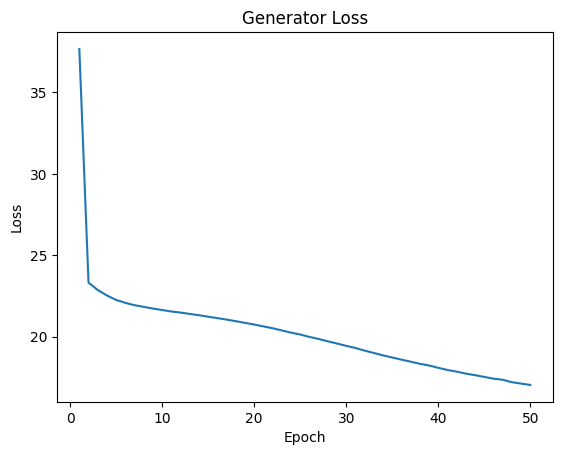

In [16]:
# Plot the generator loss graph
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.show()

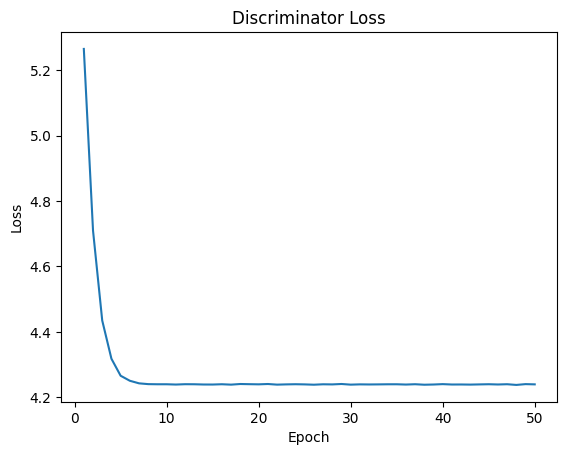

In [17]:
# Plot the discriminator loss graph
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.show()

## Test

In [18]:
# Create lists for original and generated images
Y_hat = generator(X_test)

original_images = list()
grayscale_images = list()
predicted_images = list()

for idx, (x, y, y_hat) in enumerate(zip(X_test, Y_test, Y_hat)):

    # Original RGB image
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)
    original_images.append(orig_rgb)

    # Grayscale version of the original image
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)
    grayscale_images.append(grayscale_rgb)

    # Colorized image
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)
    predicted_images.append(predicted_rgb)


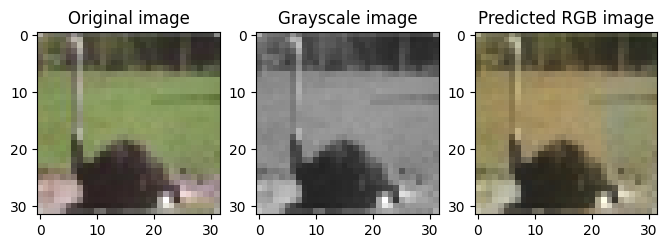

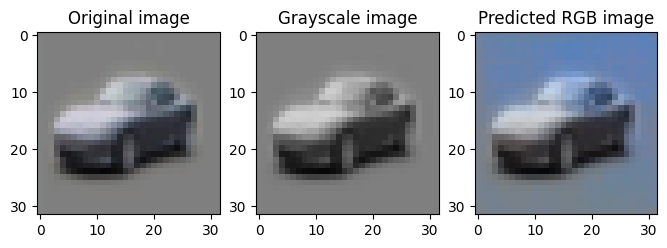

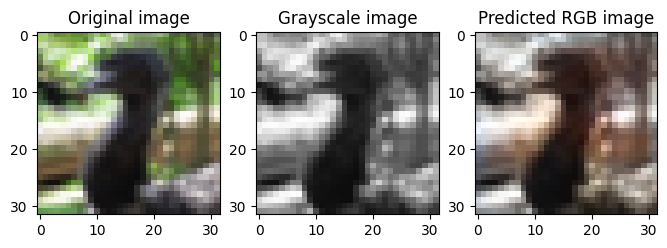

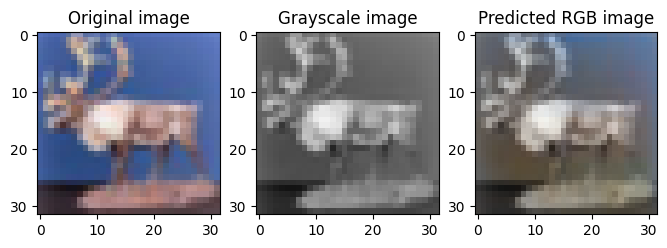

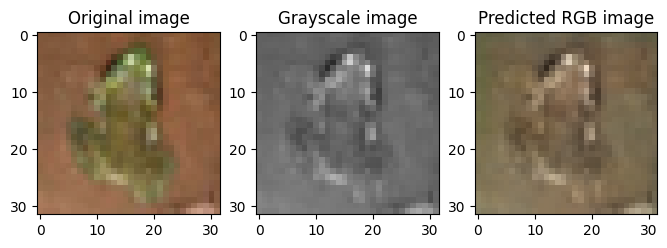

In [19]:
# Display original, grayscale, and generated images
for idx in random.sample(range(len(original_images)), 5):
    fig = plt.figure(figsize=(8, 6))
    fig.add_subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(original_images[idx])


    fig.add_subplot(1, 3, 2)
    plt.title('Grayscale image')
    plt.imshow(grayscale_images[idx])


    fig.add_subplot(1, 3, 3)
    plt.title('Predicted RGB image')
    plt.imshow(predicted_images[idx])
